## Preparations

Make sure that module can be exported in notebook

In [50]:
import sys
sys.path.append('../')

## Read ALS Level-1 point cloud file

Point cloud data from the airborne laserscanner is of processing level 1b. The product consists of structured binary files that contain a header column, a mapping variable that allows to read selected parts of the data sequentially and the data itself. 

Accessing the data is a two step process: 

### Connect to Metadata and time mapping

Connecting the binary file. In this step the metadata and time mapping variable will be parsed. This information is necessary to decode the structured binary file and allow reading only selected portions of the data file


In [51]:
from awi_als_toolbox.reader import AirborneLaserScannerFile
als_file = AirborneLaserScannerFile("ALS_L1B_20191020T014548_014709_orig", device_name_override="VQ580")

Notes:
- The laserscanner file is not part of the github repository
- the optional keyword `device_name_override` due to a limitation in the naming of scanners in the original L1B data


#### Header Information

The header information returned by `AirborneLaserScannerFile` can be found in the property `header`, which again has a list of properties:


In [52]:
als_file.header.__dict__

{'device_name_override': 'VQ580',
 'byte_size': 37,
 'scan_lines': 6727,
 'data_points_per_line': 1500,
 'bytes_per_line': 48000,
 'bytes_sec_line': 26908,
 'year': 2019,
 'month': 10,
 'day': 20,
 'start_time_sec': 6348,
 'stop_time_sec': 6428,
 'device_name': 'VQ580',
 '_status': 0,
 '_status_context': ''}

#### Start and End Time of the file

The selection of indiviual segments of the data file is realized by the timestamp, defined as the second since the start of of the UTC day. Usually between 0 and 86400, the expected behaviour for a date change in a file are seconds > 86400. The selection of data segments can only be done to the full second (integer values).

#### Order of data points

For historical reasons, the scanner data is ordered in 2D structures with the dimensions: (number of scan lines, data points per scan lines). Newer scanners however report multiple backscatter sources per shot and thus the number of data points per scan lines is not constant. In the processing, this is accounted for a larger number of data points per scan line than from the pulse-repetition frequency alone. Unused array entries in the buffer are set to NaN. 

NOTE: This will be revisited in future updates of the processing workflow, which will only a contain a list of valid returns

### Extract data

The `get_data()` method can be used to parse and decode the binary data. Without any arguments, the entire file will be parsed:

In [53]:
als = als_file.get_data()
als.dims

2020-06-10 11:35:10.083 | DEBUG    | awi_als_toolbox.reader:_get_line_range:239 - Line Range: 0 - 6631


(6632, 1500)

Specifying a time coverage in seconds will result only to read a segment of the file, e.g. a 5 second segment:

In [54]:
als = als_file.get_data(6350, 6355)
als.dims

2020-06-10 11:35:13.464 | DEBUG    | awi_als_toolbox.reader:_get_line_range:239 - Line Range: 131 - 405


(275, 1500)

The als data object has the following data properties

1. Time (UTC timestamp)
2. Longitude (degrees east)
3. Latitude (degrees)
4. Elevation (WGS84 elevations for L1B data files)

In [55]:
als.time[0, 0]

from datetime import datetime
datetime.utcfromtimestamp(als.time[0, 0])

datetime.datetime(2019, 10, 20, 1, 45, 50, 534)

In [56]:
als.longitude[0, 0]

132.70984263452954

In [57]:
als.latitude[0, 0]

85.00383585731474

In [58]:
als.elevation[0, 0]

6.764528128318489

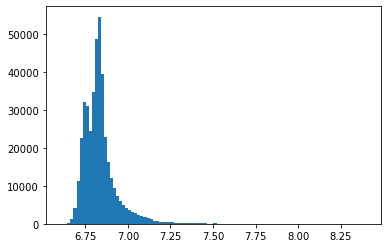

In [65]:
import numpy as np
import matplotlib.pyplot as plt 


plt.figure()
hist = plt.hist(als.elevation[np.isfinite(als.elevation)], bins=100)
